<a href="https://colab.research.google.com/github/mgczacki/iap/blob/main/libretas/Tarea2-Ej1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2: Redes Convolucionales

### Notebook 1 de 2

#### Autor: Mario Horacio Garrido Czacki

Resuelve los siguientes ejercicios en libretas de Colab independientes que sean replicables.

### 1. Diseña y entrena una red convolucional para el conjunto de datos CIFAR10. Explora diferentes diseños buscando mejorar tus resultados en el ejercicio 4 de la tarea 1. Discute tus resultados.

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
# procesamiento de imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm import trange

In [3]:
# parche para bicho en colab
# https://github.com/pytorch/vision/issues/1938
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [4]:
# directorio de datos
DATA_DIR = '../datos'

# tamaño del lote
BATCH_SIZE = 128 #NOTA: Aumentado de 32 para tomar ventaja de CUDA/reducir transferencia y maximizar paralelismo
# filas y columnas de la rejilla de imágenes

ROWS, COLS = 4, 8

classes_dataset = ['airplane',
                   'automobile',
                   'bird',
                   'cat',
                   'deer',
                   'dog',
                   'frog',
                   'horse',
                   'ship',
                   'truck']


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i])
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

In [5]:
# creamos un Dataset
ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=np.array, 
    # descargar el conjunto
    download=True
)

Files already downloaded and verified


images[0] shape=(32, 32, 3) dtype=uint8


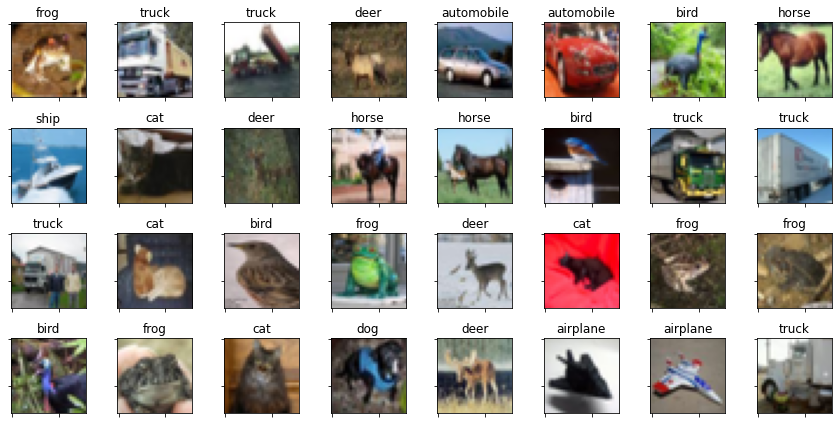

In [6]:
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [classes_dataset[y] for y in labels]
display_grid(images, titles, ROWS, COLS)

x shape=torch.Size([128, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


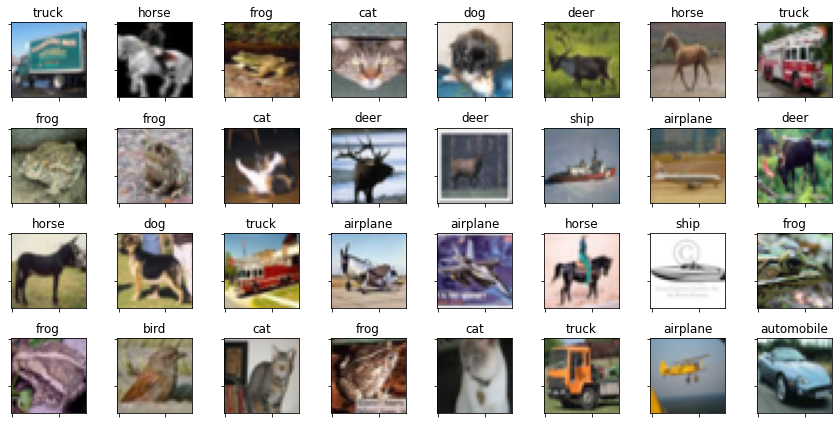

In [7]:
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, [classes_dataset[i] for i in y.tolist()], ROWS, COLS)

x shape=torch.Size([128, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


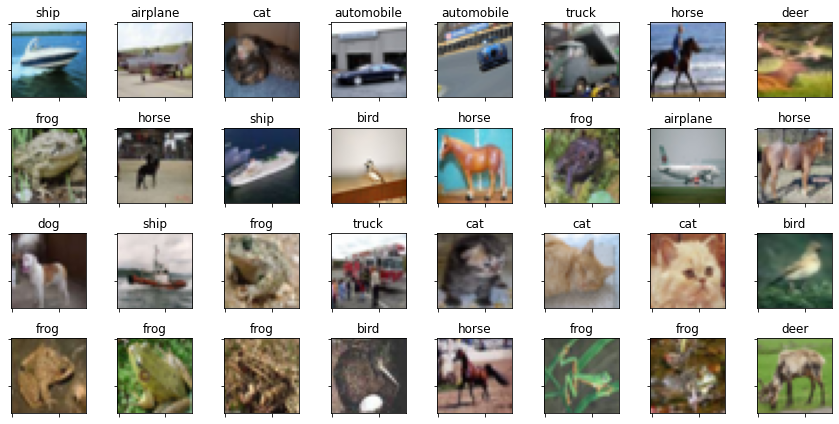

In [8]:
# creamos un Dataset
tst_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, [classes_dataset[i] for i in y.tolist()], ROWS, COLS)

In [9]:
# definición del arquitectura

#Esta primera aproximación se basa en la libreta de Fashion-MNIST vista en clase

class CNN(nn.Module):
    
    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        self.num_feats = 6 * 8 * 8

        # definición de bloques conv
        # [M, 3, 32, 32] => [M, 12, 16, 16]
        self.cnn = nn.Sequential(

            # bloque conv1
            # [M, 3, 32, 32] => [M, 12, 32, 32]
            nn.Conv2d(in_channels=3, out_channels=12, 
                      kernel_size=3, padding=1),
            # [M, 12, 32, 32]
            nn.ReLU(),
            # [M, 12, 32, 32] => [M, 12, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        
        # [M, 12, 16, 16] => [M, 6, 8, 8]
        self.cnn2 = nn.Sequential(

            # bloque conv1
            # [M, 12, 16, 16] => [M, 6, 16, 16]
            nn.Conv2d(in_channels=12, out_channels=6, 
                      kernel_size=3, padding=1),
            # [M, 6, 16, 16]
            nn.ReLU(),
            # [M, 6, 16, 16] => [M, 6, 8, 8]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )       
        # [M, 6, 8, 8] => [M, 6*8*8]
        self.flatten = nn.Flatten()

        # [M, 4x14x14] => [M, 10]
        self.cls = nn.Linear(self.num_feats, 10)
    
    # metodo para inferencia
    def forward(self, x):
        # [M, 3, 32, 32] => [M, 12, 16, 16]
        x = self.cnn(x)
         # [M, 12, 16, 16] => [M, 6, 8, 8]
        x = self.cnn2(x)
        x = self.flatten(x)
        # [M, 4x14x14] => [M, 10]
        x = self.cls(x)
        return x

In [10]:
model = CNN()
print(model)

CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn2): Sequential(
    (0): Conv2d(12, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=384, out_features=10, bias=True)
)


In [11]:
# inferencia con datos sintéticos
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 32, 32]) => torch.Size([1, 10])


In [12]:
summary(model, (1, 3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 12, 16, 16]           --
|    └─Conv2d: 2-1                       [1, 12, 32, 32]           336
|    └─ReLU: 2-2                         [1, 12, 32, 32]           --
|    └─MaxPool2d: 2-3                    [1, 12, 16, 16]           --
├─Sequential: 1-2                        [1, 6, 8, 8]              --
|    └─Conv2d: 2-4                       [1, 6, 16, 16]            654
|    └─ReLU: 2-5                         [1, 6, 16, 16]            --
|    └─MaxPool2d: 2-6                    [1, 6, 8, 8]              --
├─Flatten: 1-3                           [1, 384]                  --
├─Linear: 1-4                            [1, 10]                   3,850
Total params: 4,840
Trainable params: 4,840
Non-trainable params: 0
Total mult-adds (M): 0.50
Input size (MB): 0.01
Forward/backward pass size (MB): 0.11
Params size (MB): 0.02
Estimated Total Size (MB): 0.14

#### Uso del GPU

In [13]:
#Para usar el GPU si hay
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        y_true = y_true.to(device)
        
        # computamos logits
        y_lgts = model(x.to(device))
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):
            y_true = y_true.to(device)
            
            # computamos los logits
            y_lgts = model(x.to(device))

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
#Modificado para poder continuar el entrenamiento
# Se mantienen historiales de pérdida y se puede pasar el optimizador para los que utilizan momentum.
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None, optimizer = optim.SGD, opt = None, loss_hist = [], acc_hist = []):

    # historiales
    #loss_hist, acc_hist = [], []
    
    # optimizador
    if not opt:
        opt = optimizer(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist, opt

In [15]:
# instanciamos un modelo
model = CNN().to(device)
# entrenamos
loss_hist, acc_hist, model_opt = train(model, trn_dl, tst_dl)

  5%|▌         | 1/20 [00:11<03:46, 11.94s/it]

E00 loss=[230.35,230.30] acc=[10.17,10.70]


 10%|█         | 2/20 [00:23<03:31, 11.72s/it]

E01 loss=[230.09,230.07] acc=[11.36,11.90]


 15%|█▌        | 3/20 [00:35<03:19, 11.71s/it]

E02 loss=[229.85,229.85] acc=[13.71,14.24]


 20%|██        | 4/20 [00:45<03:01, 11.32s/it]

E03 loss=[229.55,229.49] acc=[14.15,14.62]


 25%|██▌       | 5/20 [00:56<02:46, 11.08s/it]

E04 loss=[229.17,229.07] acc=[13.89,14.33]


 30%|███       | 6/20 [01:07<02:36, 11.17s/it]

E05 loss=[228.65,228.59] acc=[13.74,14.33]


 35%|███▌      | 7/20 [01:19<02:27, 11.36s/it]

E06 loss=[227.94,227.88] acc=[14.47,14.48]


 40%|████      | 8/20 [01:31<02:16, 11.38s/it]

E07 loss=[226.95,226.93] acc=[16.30,16.40]


 45%|████▌     | 9/20 [01:42<02:04, 11.36s/it]

E08 loss=[225.54,225.41] acc=[18.69,19.08]


 50%|█████     | 10/20 [01:53<01:52, 11.24s/it]

E09 loss=[223.54,223.30] acc=[20.31,20.95]


 55%|█████▌    | 11/20 [02:04<01:40, 11.19s/it]

E10 loss=[220.69,220.44] acc=[22.30,22.98]


 60%|██████    | 12/20 [02:15<01:28, 11.09s/it]

E11 loss=[216.95,216.65] acc=[24.07,24.79]


 65%|██████▌   | 13/20 [02:26<01:18, 11.17s/it]

E12 loss=[212.67,212.26] acc=[24.85,25.83]


 70%|███████   | 14/20 [02:37<01:06, 11.08s/it]

E13 loss=[208.64,207.95] acc=[25.44,26.54]


 75%|███████▌  | 15/20 [02:48<00:54, 10.90s/it]

E14 loss=[205.44,204.75] acc=[26.55,27.50]


 80%|████████  | 16/20 [02:58<00:43, 10.80s/it]

E15 loss=[203.15,202.22] acc=[27.36,28.61]


 85%|████████▌ | 17/20 [03:09<00:32, 10.74s/it]

E16 loss=[201.45,200.44] acc=[27.87,28.79]


 90%|█████████ | 18/20 [03:19<00:21, 10.63s/it]

E17 loss=[200.15,198.98] acc=[28.85,30.06]


 95%|█████████▌| 19/20 [03:30<00:10, 10.58s/it]

E18 loss=[198.97,198.15] acc=[29.10,30.07]


100%|██████████| 20/20 [03:40<00:00, 11.02s/it]

E19 loss=[197.94,197.33] acc=[29.91,30.84]


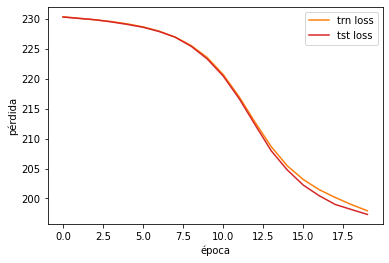

In [16]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

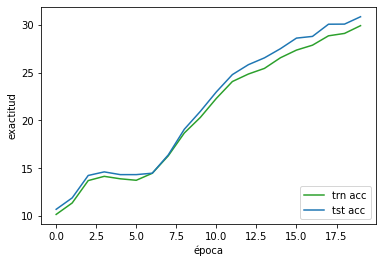

In [17]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

#### Evaluación

In [18]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[197.93,196.84] acc=[29.90,30.98]


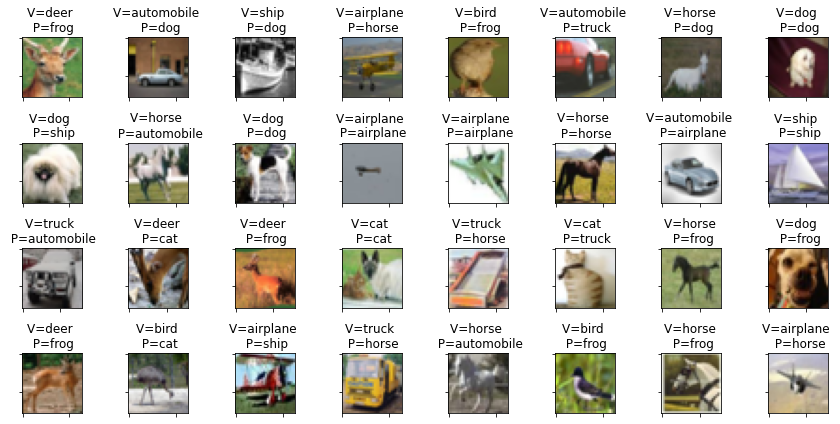

In [19]:
with torch.no_grad(): 
    x_o, y_true_o = next(iter(tst_dl))
    x = x_o.to(device)
    y_true = y_true_o.to(device)
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1).cpu()
    titles = [f'V={t} \n P={p}' for t, p in zip([classes_dataset[i] for i in y_true_o], 
                                                [classes_dataset[i] for i in y_pred])]
    display_batch(x_o, titles, ROWS, COLS)

En este caso es notable que la convergencia es relativamente lenta. Las funciones de pérdida parecen no haberse estancado así que entrenaré por 40 más épocas. Mantendré los historiales de entrenamiento previos.

In [20]:
loss_hist, acc_hist, model_opt = train(model, trn_dl, tst_dl, epochs = 40, opt = model_opt, loss_hist = loss_hist, acc_hist = acc_hist)

  2%|▎         | 1/40 [00:10<06:53, 10.61s/it]

E00 loss=[196.99,196.02] acc=[30.43,31.25]


  5%|▌         | 2/40 [00:21<06:44, 10.65s/it]

E01 loss=[196.00,194.90] acc=[30.89,31.61]


  8%|▊         | 3/40 [00:32<06:35, 10.70s/it]

E02 loss=[195.13,194.04] acc=[31.13,31.84]


 10%|█         | 4/40 [00:42<06:25, 10.70s/it]

E03 loss=[194.26,193.51] acc=[31.76,32.08]


 12%|█▎        | 5/40 [00:53<06:12, 10.64s/it]

E04 loss=[193.49,192.97] acc=[31.85,31.94]


 15%|█▌        | 6/40 [01:03<06:02, 10.65s/it]

E05 loss=[192.63,191.90] acc=[32.69,32.78]


 18%|█▊        | 7/40 [01:14<05:50, 10.61s/it]

E06 loss=[191.73,191.09] acc=[33.08,33.47]


 20%|██        | 8/40 [01:25<05:40, 10.63s/it]

E07 loss=[191.12,190.61] acc=[33.28,33.49]


 22%|██▎       | 9/40 [01:35<05:29, 10.63s/it]

E08 loss=[190.20,189.26] acc=[33.82,33.95]


 25%|██▌       | 10/40 [01:46<05:17, 10.57s/it]

E09 loss=[189.46,188.88] acc=[34.08,33.96]


 28%|██▊       | 11/40 [01:57<05:08, 10.65s/it]

E10 loss=[188.85,188.33] acc=[34.06,33.74]


 30%|███       | 12/40 [02:07<04:57, 10.64s/it]

E11 loss=[188.17,187.64] acc=[34.36,34.56]


 32%|███▎      | 13/40 [02:18<04:47, 10.64s/it]

E12 loss=[187.52,187.09] acc=[34.64,34.43]


 35%|███▌      | 14/40 [02:28<04:36, 10.65s/it]

E13 loss=[186.92,186.62] acc=[34.89,34.76]


 38%|███▊      | 15/40 [02:39<04:26, 10.68s/it]

E14 loss=[186.29,186.29] acc=[34.89,35.17]


 40%|████      | 16/40 [02:50<04:15, 10.66s/it]

E15 loss=[185.88,185.18] acc=[35.14,35.30]


 42%|████▎     | 17/40 [03:00<04:05, 10.65s/it]

E16 loss=[185.05,184.50] acc=[35.60,35.33]


 45%|████▌     | 18/40 [03:11<03:53, 10.62s/it]

E17 loss=[184.46,184.04] acc=[35.68,35.60]


 48%|████▊     | 19/40 [03:22<03:44, 10.68s/it]

E18 loss=[183.92,183.54] acc=[36.00,35.87]


 50%|█████     | 20/40 [03:33<03:34, 10.70s/it]

E19 loss=[183.69,183.62] acc=[35.77,35.92]


 52%|█████▎    | 21/40 [03:43<03:22, 10.66s/it]

E20 loss=[182.74,182.33] acc=[36.11,36.10]


 55%|█████▌    | 22/40 [03:54<03:11, 10.66s/it]

E21 loss=[182.31,181.80] acc=[36.21,36.67]


 57%|█████▊    | 23/40 [04:04<03:01, 10.66s/it]

E22 loss=[182.39,182.25] acc=[36.79,36.22]


 60%|██████    | 24/40 [04:15<02:50, 10.64s/it]

E23 loss=[181.14,181.17] acc=[36.84,36.81]


 62%|██████▎   | 25/40 [04:26<02:39, 10.64s/it]

E24 loss=[180.36,180.15] acc=[36.95,37.04]


 65%|██████▌   | 26/40 [04:36<02:28, 10.59s/it]

E25 loss=[179.35,179.28] acc=[37.68,37.89]


 68%|██████▊   | 27/40 [04:47<02:18, 10.67s/it]

E26 loss=[179.03,178.84] acc=[37.22,37.19]


 70%|███████   | 28/40 [04:58<02:08, 10.70s/it]

E27 loss=[178.10,177.86] acc=[38.14,37.96]


 72%|███████▎  | 29/40 [05:08<01:57, 10.64s/it]

E28 loss=[177.17,177.20] acc=[38.33,38.35]


 75%|███████▌  | 30/40 [05:19<01:46, 10.63s/it]

E29 loss=[176.54,176.14] acc=[38.52,38.62]


 78%|███████▊  | 31/40 [05:29<01:35, 10.60s/it]

E30 loss=[175.74,176.04] acc=[38.78,38.92]


 80%|████████  | 32/40 [05:40<01:25, 10.67s/it]

E31 loss=[175.05,174.70] acc=[39.05,39.14]


 82%|████████▎ | 33/40 [05:51<01:14, 10.63s/it]

E32 loss=[174.12,173.78] acc=[39.33,39.41]


 85%|████████▌ | 34/40 [06:02<01:04, 10.69s/it]

E33 loss=[172.89,172.68] acc=[39.85,39.88]


 88%|████████▊ | 35/40 [06:12<00:53, 10.70s/it]

E34 loss=[172.04,171.85] acc=[40.21,40.34]


 90%|█████████ | 36/40 [06:23<00:42, 10.71s/it]

E35 loss=[171.14,170.87] acc=[40.35,40.14]


 92%|█████████▎| 37/40 [06:34<00:32, 10.70s/it]

E36 loss=[170.38,170.83] acc=[40.88,40.63]


 95%|█████████▌| 38/40 [06:44<00:21, 10.70s/it]

E37 loss=[169.53,169.41] acc=[41.17,40.95]


 98%|█████████▊| 39/40 [06:55<00:10, 10.70s/it]

E38 loss=[168.37,168.22] acc=[41.45,41.12]


100%|██████████| 40/40 [07:06<00:00, 10.66s/it]

E39 loss=[167.41,167.43] acc=[41.58,41.49]


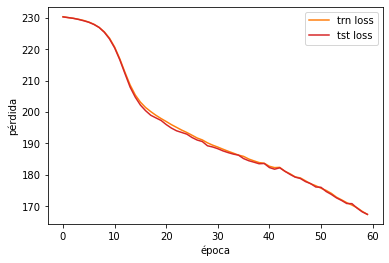

In [21]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

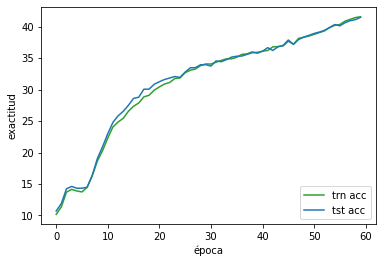

In [22]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

Parece seguir ligeramente subentrenada la red. Unas 40 épocas más podrían funcionar bien.

In [23]:
loss_hist, acc_hist, model_opt = train(model, trn_dl, tst_dl, epochs = 40, opt = model_opt, loss_hist = loss_hist, acc_hist = acc_hist)

  2%|▎         | 1/40 [00:10<06:52, 10.58s/it]

E00 loss=[166.38,166.70] acc=[42.22,42.41]


  5%|▌         | 2/40 [00:21<06:41, 10.57s/it]

E01 loss=[166.08,166.03] acc=[42.12,41.75]


  8%|▊         | 3/40 [00:31<06:31, 10.59s/it]

E02 loss=[164.81,164.94] acc=[42.38,42.68]


 10%|█         | 4/40 [00:42<06:21, 10.59s/it]

E03 loss=[164.37,164.25] acc=[42.78,42.58]


 12%|█▎        | 5/40 [00:52<06:10, 10.58s/it]

E04 loss=[163.63,163.82] acc=[42.85,42.45]


 15%|█▌        | 6/40 [01:03<06:00, 10.61s/it]

E05 loss=[162.34,162.75] acc=[43.29,43.10]


 18%|█▊        | 7/40 [01:14<05:49, 10.59s/it]

E06 loss=[161.62,161.77] acc=[43.36,43.63]


 20%|██        | 8/40 [01:24<05:39, 10.60s/it]

E07 loss=[160.91,160.69] acc=[43.79,43.84]


 22%|██▎       | 9/40 [01:35<05:29, 10.64s/it]

E08 loss=[160.24,160.90] acc=[43.99,43.85]


 25%|██▌       | 10/40 [01:46<05:19, 10.66s/it]

E09 loss=[160.27,160.35] acc=[43.73,43.65]


 28%|██▊       | 11/40 [01:56<05:08, 10.63s/it]

E10 loss=[159.47,159.20] acc=[44.16,44.23]


 30%|███       | 12/40 [02:07<04:58, 10.66s/it]

E11 loss=[158.42,158.28] acc=[44.08,44.25]


 32%|███▎      | 13/40 [02:18<04:48, 10.67s/it]

E12 loss=[157.52,157.76] acc=[44.67,45.06]


 35%|███▌      | 14/40 [02:28<04:37, 10.68s/it]

E13 loss=[157.04,157.19] acc=[44.72,44.86]


 38%|███▊      | 15/40 [02:39<04:25, 10.63s/it]

E14 loss=[156.44,156.24] acc=[44.65,44.59]


 40%|████      | 16/40 [02:50<04:15, 10.65s/it]

E15 loss=[156.22,156.15] acc=[45.50,45.56]


 42%|████▎     | 17/40 [03:00<04:04, 10.63s/it]

E16 loss=[155.43,155.51] acc=[45.31,45.55]


 45%|████▌     | 18/40 [03:11<03:54, 10.67s/it]

E17 loss=[154.95,155.37] acc=[45.58,45.45]


 48%|████▊     | 19/40 [03:22<03:45, 10.73s/it]

E18 loss=[154.62,154.60] acc=[45.40,45.17]


 50%|█████     | 20/40 [03:32<03:33, 10.68s/it]

E19 loss=[153.78,154.13] acc=[46.04,45.96]


 52%|█████▎    | 21/40 [03:43<03:22, 10.65s/it]

E20 loss=[153.85,153.94] acc=[45.75,45.63]


 55%|█████▌    | 22/40 [03:54<03:11, 10.63s/it]

E21 loss=[153.01,152.93] acc=[46.36,46.38]


 57%|█████▊    | 23/40 [04:04<03:01, 10.66s/it]

E22 loss=[153.88,153.93] acc=[45.42,45.36]


 60%|██████    | 24/40 [04:15<02:50, 10.68s/it]

E23 loss=[152.14,152.33] acc=[46.67,46.55]


 62%|██████▎   | 25/40 [04:26<02:39, 10.65s/it]

E24 loss=[152.24,152.40] acc=[46.52,46.01]


 65%|██████▌   | 26/40 [04:36<02:28, 10.63s/it]

E25 loss=[151.54,151.86] acc=[46.89,46.75]


 68%|██████▊   | 27/40 [04:47<02:18, 10.66s/it]

E26 loss=[151.30,151.39] acc=[46.76,46.59]


 70%|███████   | 28/40 [04:57<02:07, 10.62s/it]

E27 loss=[150.97,151.53] acc=[46.82,46.51]


 72%|███████▎  | 29/40 [05:08<01:56, 10.60s/it]

E28 loss=[151.11,151.21] acc=[47.02,46.67]


 75%|███████▌  | 30/40 [05:18<01:45, 10.58s/it]

E29 loss=[150.12,151.08] acc=[47.25,46.94]


 78%|███████▊  | 31/40 [05:29<01:35, 10.58s/it]

E30 loss=[150.26,150.27] acc=[47.13,46.91]


 80%|████████  | 32/40 [05:40<01:25, 10.70s/it]

E31 loss=[150.55,151.12] acc=[46.81,46.81]


 82%|████████▎ | 33/40 [05:51<01:15, 10.85s/it]

E32 loss=[149.94,150.21] acc=[46.75,46.55]


 85%|████████▌ | 34/40 [06:02<01:05, 10.85s/it]

E33 loss=[150.10,149.99] acc=[47.09,47.36]


 88%|████████▊ | 35/40 [06:13<00:54, 10.94s/it]

E34 loss=[149.32,150.29] acc=[47.31,46.71]


 90%|█████████ | 36/40 [06:24<00:43, 10.91s/it]

E35 loss=[150.50,151.10] acc=[47.43,47.06]


 92%|█████████▎| 37/40 [06:35<00:32, 10.91s/it]

E36 loss=[148.98,149.46] acc=[47.67,47.14]


 95%|█████████▌| 38/40 [06:46<00:21, 10.92s/it]

E37 loss=[148.58,148.64] acc=[47.80,47.54]


 98%|█████████▊| 39/40 [06:57<00:10, 10.97s/it]

E38 loss=[148.75,149.54] acc=[47.19,46.85]


100%|██████████| 40/40 [07:08<00:00, 10.71s/it]

E39 loss=[148.22,148.79] acc=[47.50,47.01]


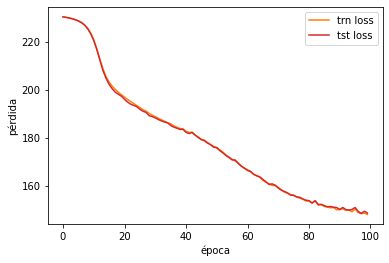

In [24]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

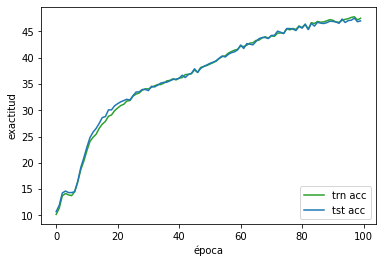

In [25]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

#### Evaluación

In [26]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[148.24,148.69] acc=[47.49,46.88]


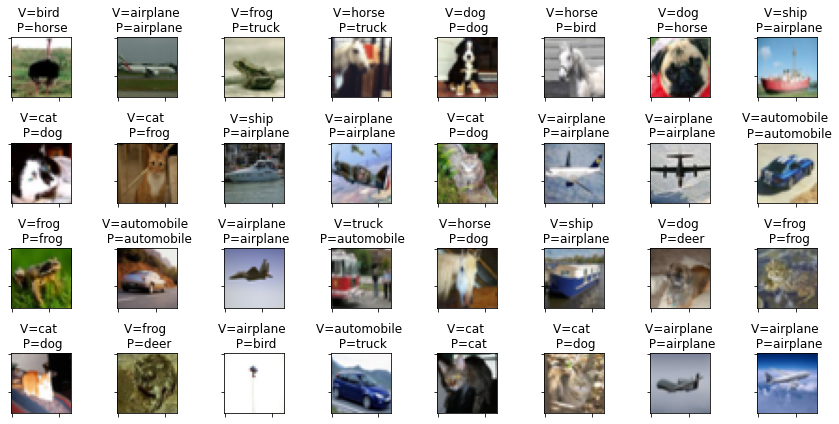

In [27]:
with torch.no_grad(): 
    x_o, y_true_o = next(iter(tst_dl))
    x = x_o.to(device)
    y_true = y_true_o.to(device)
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1).cpu()
    titles = [f'V={t} \n P={p}' for t, p in zip([classes_dataset[i] for i in y_true_o], 
                                                [classes_dataset[i] for i in y_pred])]
    display_batch(x_o, titles, ROWS, COLS)

La convergencia es sumamente lenta para este punto. De igual manera, parece que poco a poco se está llegando a una meseta de entrenamiento por lo que es posible que sea buena idea volver la arquitectura de la red más compleja. De igual manera, utilizar Adam podría acelerar la convergencia.

### Intento 2

In [60]:
# definición del arquitectura

class CNN(nn.Module):
    
    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        self.num_feats = 24 * 4 * 4

        # definición de bloques conv
        # [M, 3, 32, 32] => [M, 12, 16, 16]
        self.cnn = nn.Sequential(

            # bloque conv1
            # [M, 3, 32, 32] => [M, 12, 32, 32]
            nn.Conv2d(in_channels=3, out_channels=12, 
                      kernel_size=3, padding=1),
            # [M, 12, 32, 32]
            nn.ReLU(),
            # [M, 12, 32, 32] => [M, 12, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        
        # [M, 12, 16, 16] => [M, 18, 8, 8]
        self.cnn2 = nn.Sequential(

            # bloque conv2
            # [M, 12, 16, 16] => [M, 18, 16, 16]
            nn.Conv2d(in_channels=12, out_channels=18, 
                      kernel_size=3, padding=1),
            # [M, 18, 16, 16]
            nn.ReLU(),
            # [M, 18, 16, 16] => [M, 18, 8, 8]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        
        # [M, 18, 8, 8] => [M, 24, 4, 4]
        self.cnn3 = nn.Sequential(

            # bloque conv3
            # [M, 18, 8, 8] => [M, 24, 8, 8]
            nn.Conv2d(in_channels=18, out_channels=24, 
                      kernel_size=3, padding=1),
            # [M, 24, 8, 8]
            nn.ReLU(),
            # [M, 24, 8, 8] => [M, 24, 4, 4]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        
        # [M, 24, 4, 4] => [M, 24 * 4 * 4]
        self.flatten = nn.Flatten()
        
        # [M, 24 * 4 * 4] => [M, 10]
        self.cls = nn.Linear(self.num_feats, 10)
        
    # metodo para inferencia
    def forward(self, x):
        # [M, 3, 32, 32] => [M, 12, 16, 16]
        x = self.cnn(x)
         # [M, 12, 16, 16] => [M, 18, 8, 8]
        x = self.cnn2(x)
        # [M, 18, 8, 8] => [M, 24, 4, 4]
        x = self.cnn3(x)
        # [M, 24, 4, 4] => [M, 10, 1, 1]
        x = self.flatten(x)
        x = self.cls(x)
        return x

In [61]:
model = CNN()
print(model)

CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn2): Sequential(
    (0): Conv2d(12, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn3): Sequential(
    (0): Conv2d(18, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=384, out_features=10, bias=True)
)


In [62]:
# inferencia con datos sintéticos
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 32, 32]) => torch.Size([1, 10])


In [63]:
summary(model, (1, 3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 12, 16, 16]           --
|    └─Conv2d: 2-1                       [1, 12, 32, 32]           336
|    └─ReLU: 2-2                         [1, 12, 32, 32]           --
|    └─MaxPool2d: 2-3                    [1, 12, 16, 16]           --
├─Sequential: 1-2                        [1, 18, 8, 8]             --
|    └─Conv2d: 2-4                       [1, 18, 16, 16]           1,962
|    └─ReLU: 2-5                         [1, 18, 16, 16]           --
|    └─MaxPool2d: 2-6                    [1, 18, 8, 8]             --
├─Sequential: 1-3                        [1, 24, 4, 4]             --
|    └─Conv2d: 2-7                       [1, 24, 8, 8]             3,912
|    └─ReLU: 2-8                         [1, 24, 8, 8]             --
|    └─MaxPool2d: 2-9                    [1, 24, 4, 4]             --
├─Flatten: 1-4                           [1, 384]                  --
├─Linear

In [64]:
model = CNN().to(device)
loss_hist, acc_hist, model_opt = train(model, trn_dl, tst_dl, opt = None, optimizer = optim.Adam, epochs = 20, lr = 1e-3, loss_hist = [], acc_hist = [])

  5%|▌         | 1/20 [00:12<03:56, 12.45s/it]

E00 loss=[160.24,159.83] acc=[43.35,43.27]


 10%|█         | 2/20 [00:25<03:46, 12.59s/it]

E01 loss=[147.00,147.60] acc=[47.02,46.82]


 15%|█▌        | 3/20 [00:38<03:38, 12.83s/it]

E02 loss=[143.47,144.34] acc=[49.04,49.11]


 20%|██        | 4/20 [00:51<03:28, 13.04s/it]

E03 loss=[130.53,131.45] acc=[53.86,52.87]


 25%|██▌       | 5/20 [01:04<03:14, 12.97s/it]

E04 loss=[122.57,124.36] acc=[56.65,56.10]


 30%|███       | 6/20 [01:16<02:57, 12.70s/it]

E05 loss=[118.66,120.38] acc=[58.41,57.48]


 35%|███▌      | 7/20 [01:28<02:39, 12.28s/it]

E06 loss=[114.44,116.49] acc=[59.82,59.08]


 40%|████      | 8/20 [01:39<02:23, 11.93s/it]

E07 loss=[112.31,113.82] acc=[60.78,60.17]


 45%|████▌     | 9/20 [01:50<02:07, 11.59s/it]

E08 loss=[108.56,111.51] acc=[62.23,61.14]


 50%|█████     | 10/20 [02:01<01:55, 11.52s/it]

E09 loss=[107.08,110.24] acc=[62.70,61.53]


 55%|█████▌    | 11/20 [02:12<01:42, 11.38s/it]

E10 loss=[103.12,106.21] acc=[63.87,62.75]


 60%|██████    | 12/20 [02:23<01:29, 11.25s/it]

E11 loss=[102.21,107.52] acc=[64.26,62.65]


 65%|██████▌   | 13/20 [02:34<01:18, 11.21s/it]

E12 loss=[ 99.48,104.20] acc=[65.37,63.52]


 70%|███████   | 14/20 [02:45<01:07, 11.19s/it]

E13 loss=[ 98.18,103.26] acc=[65.47,63.80]


 75%|███████▌  | 15/20 [02:56<00:55, 11.16s/it]

E14 loss=[ 96.45,101.49] acc=[66.65,64.63]


 80%|████████  | 16/20 [03:07<00:44, 11.16s/it]

E15 loss=[ 97.29,102.64] acc=[66.10,64.05]


 85%|████████▌ | 17/20 [03:18<00:33, 11.09s/it]

E16 loss=[ 97.63,104.86] acc=[65.61,63.64]


 90%|█████████ | 18/20 [03:30<00:22, 11.09s/it]

E17 loss=[ 92.80, 99.69] acc=[67.87,65.95]


 95%|█████████▌| 19/20 [03:40<00:11, 11.03s/it]

E18 loss=[ 93.01,100.25] acc=[67.68,65.14]


100%|██████████| 20/20 [03:51<00:00, 11.59s/it]

E19 loss=[ 90.33, 97.41] acc=[68.55,66.00]


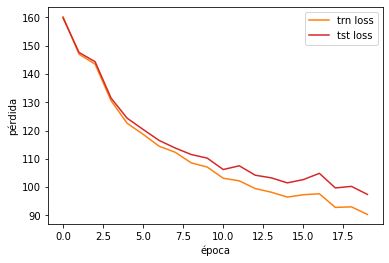

In [65]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

Ya se notan mejores resultados que en la red pasada. Intentaré entrenar 30 épocas más.

In [66]:
loss_hist, acc_hist, model_opt = train(model, trn_dl, tst_dl, epochs = 30, opt = model_opt, loss_hist = loss_hist, acc_hist = acc_hist)

  3%|▎         | 1/30 [00:11<05:20, 11.05s/it]

E00 loss=[ 90.44, 97.87] acc=[68.52,66.13]


  7%|▋         | 2/30 [00:22<05:21, 11.49s/it]

E01 loss=[ 90.26, 98.05] acc=[68.89,65.99]


 10%|█         | 3/30 [00:35<05:29, 12.22s/it]

E02 loss=[ 86.46, 94.65] acc=[70.27,67.52]


 13%|█▎        | 4/30 [00:47<05:15, 12.12s/it]

E03 loss=[ 91.06, 99.82] acc=[68.71,65.56]


 17%|█▋        | 5/30 [00:59<05:01, 12.08s/it]

E04 loss=[ 85.56, 94.73] acc=[70.41,67.27]


 20%|██        | 6/30 [01:11<04:49, 12.06s/it]

E05 loss=[ 86.68, 95.43] acc=[70.20,67.15]


 23%|██▎       | 7/30 [01:23<04:34, 11.94s/it]

E06 loss=[ 85.05, 94.17] acc=[70.29,67.70]


 27%|██▋       | 8/30 [01:35<04:22, 11.95s/it]

E07 loss=[ 83.10, 92.37] acc=[71.18,67.99]


 30%|███       | 9/30 [01:47<04:07, 11.79s/it]

E08 loss=[ 83.15, 92.60] acc=[71.13,67.92]


 33%|███▎      | 10/30 [01:59<03:59, 11.96s/it]

E09 loss=[ 84.41, 94.93] acc=[70.46,68.07]


 37%|███▋      | 11/30 [02:12<03:52, 12.22s/it]

E10 loss=[ 81.10, 91.97] acc=[71.93,68.79]


 40%|████      | 12/30 [02:24<03:41, 12.33s/it]

E11 loss=[ 81.16, 92.09] acc=[71.98,68.32]


 43%|████▎     | 13/30 [02:37<03:31, 12.42s/it]

E12 loss=[ 79.83, 90.90] acc=[72.43,69.03]


 47%|████▋     | 14/30 [02:50<03:20, 12.52s/it]

E13 loss=[ 82.87, 95.14] acc=[71.40,67.55]


 50%|█████     | 15/30 [03:03<03:09, 12.64s/it]

E14 loss=[ 78.86, 90.88] acc=[72.95,68.55]


 53%|█████▎    | 16/30 [03:15<02:56, 12.61s/it]

E15 loss=[ 81.30, 93.90] acc=[72.03,67.32]


 57%|█████▋    | 17/30 [03:27<02:42, 12.49s/it]

E16 loss=[ 80.68, 93.12] acc=[71.95,67.74]


 60%|██████    | 18/30 [03:40<02:29, 12.43s/it]

E17 loss=[ 77.18, 90.41] acc=[73.37,69.22]


 63%|██████▎   | 19/30 [03:52<02:17, 12.46s/it]

E18 loss=[ 76.45, 89.18] acc=[73.70,69.70]


 67%|██████▋   | 20/30 [04:05<02:04, 12.46s/it]

E19 loss=[ 77.24, 90.88] acc=[73.15,68.99]


 70%|███████   | 21/30 [04:17<01:52, 12.49s/it]

E20 loss=[ 75.44, 90.04] acc=[74.01,69.32]


 73%|███████▎  | 22/30 [04:30<01:39, 12.47s/it]

E21 loss=[ 78.69, 93.41] acc=[72.96,67.53]


 77%|███████▋  | 23/30 [04:42<01:26, 12.42s/it]

E22 loss=[ 74.24, 88.91] acc=[74.27,69.49]


 80%|████████  | 24/30 [04:54<01:14, 12.40s/it]

E23 loss=[ 74.62, 89.15] acc=[74.16,69.58]


 83%|████████▎ | 25/30 [05:07<01:01, 12.39s/it]

E24 loss=[ 73.29, 88.56] acc=[74.69,69.83]


 87%|████████▋ | 26/30 [05:19<00:49, 12.35s/it]

E25 loss=[ 76.34, 90.75] acc=[73.36,69.17]


 90%|█████████ | 27/30 [05:31<00:37, 12.38s/it]

E26 loss=[ 74.68, 90.85] acc=[74.15,69.32]


 93%|█████████▎| 28/30 [05:44<00:24, 12.43s/it]

E27 loss=[ 74.18, 91.40] acc=[74.24,68.98]


 97%|█████████▋| 29/30 [05:56<00:12, 12.39s/it]

E28 loss=[ 74.91, 91.26] acc=[74.04,69.20]


100%|██████████| 30/30 [06:09<00:00, 12.31s/it]

E29 loss=[ 72.77, 89.47] acc=[74.95,69.67]


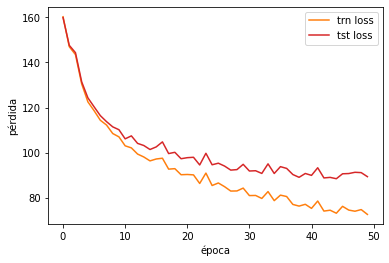

In [67]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

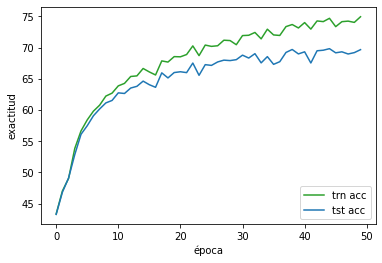

In [68]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

Parece que se llegó a una meseta de entrenamiento. Una mejor arquitectura sería necesaria.

#### Evaluación

In [69]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 72.77, 90.06] acc=[74.94,69.53]


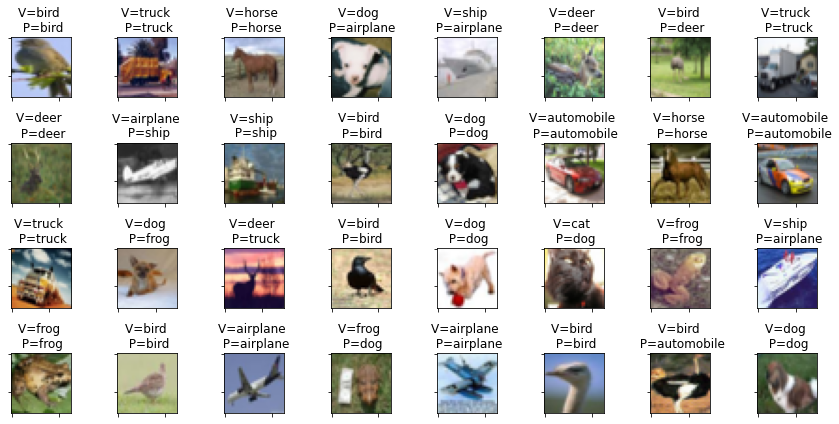

In [70]:
with torch.no_grad(): 
    x_o, y_true_o = next(iter(tst_dl))
    x = x_o.to(device)
    y_true = y_true_o.to(device)
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1).cpu()
    titles = [f'V={t} \n P={p}' for t, p in zip([classes_dataset[i] for i in y_true_o], 
                                                [classes_dataset[i] for i in y_pred])]
    display_batch(x_o, titles, ROWS, COLS)

No obstante de que la red siga teniendo sus problemas, es claro que tiene un desempeño notablemente mejor que la red fully-connected de la tarea 1.

### Intento 3

In [75]:
# definición del arquitectura

class CNN(nn.Module):
    
    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        self.num_feats = 32 * 4 * 4

        # definición de bloques conv
        # [M, 3, 32, 32] => [M, 24, 16, 16]
        self.cnn = nn.Sequential(

            # bloque conv1
            # [M, 3, 32, 32] => [M, 24, 32, 32]
            nn.Conv2d(in_channels=3, out_channels=24, 
                      kernel_size=3, padding=1),
            # [M, 12, 32, 32]
            nn.ReLU(),
            # [M, 12, 32, 32] => [M, 24, 16, 16]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        
        # [M, 24, 16, 16] => [M, 48, 8, 8]
        self.cnn2 = nn.Sequential(

            # bloque conv2
            # [M, 24, 16, 16] => [M, 48, 16, 16]
            nn.Conv2d(in_channels=24, out_channels=48, 
                      kernel_size=3, padding=1),
            # [M, 48, 16, 16]
            nn.ReLU(),
            # [M, 48, 16, 16] => [M, 48, 8, 8]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        
        # [M, 48, 8, 8] => [M, 24, 4, 4]
        self.cnn3 = nn.Sequential(

            # bloque conv3
            # [M, 48, 8, 8] => [M, 32, 8, 8]
            nn.Conv2d(in_channels=48, out_channels=32, 
                      kernel_size=3, padding=1),
            # [M, 32, 8, 8]
            nn.ReLU(),
            # [M, 32, 8, 8] => [M, 32, 4, 4]
            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        
        # [M, 24, 4, 4] => [M, 24 * 4 * 4]
        self.flatten = nn.Flatten()
        
        # [M, 24 * 4 * 4] => [M, 10]
        self.cls = nn.Linear(self.num_feats, 10)
        
    # metodo para inferencia
    def forward(self, x):
        # [M, 3, 32, 32] => [M, 24, 16, 16]
        x = self.cnn(x)
         # [M, 24, 16, 16] => [M, 48, 8, 8]
        x = self.cnn2(x)
        # [M, 48, 8, 8] => [M, 32, 4, 4]
        x = self.cnn3(x)
        # [M, 32, 4, 4] => [M, 10, 1, 1]
        x = self.flatten(x)
        x = self.cls(x)
        return x

In [80]:
model = CNN()
print(model)

CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn2): Sequential(
    (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn3): Sequential(
    (0): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cls): Linear(in_features=512, out_features=10, bias=True)
)


In [81]:
# inferencia con datos sintéticos
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 32, 32]) => torch.Size([1, 10])


In [82]:
summary(model, (1, 3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 24, 16, 16]           --
|    └─Conv2d: 2-1                       [1, 24, 32, 32]           672
|    └─ReLU: 2-2                         [1, 24, 32, 32]           --
|    └─MaxPool2d: 2-3                    [1, 24, 16, 16]           --
├─Sequential: 1-2                        [1, 48, 8, 8]             --
|    └─Conv2d: 2-4                       [1, 48, 16, 16]           10,416
|    └─ReLU: 2-5                         [1, 48, 16, 16]           --
|    └─MaxPool2d: 2-6                    [1, 48, 8, 8]             --
├─Sequential: 1-3                        [1, 32, 4, 4]             --
|    └─Conv2d: 2-7                       [1, 32, 8, 8]             13,856
|    └─ReLU: 2-8                         [1, 32, 8, 8]             --
|    └─MaxPool2d: 2-9                    [1, 32, 4, 4]             --
├─Flatten: 1-4                           [1, 512]                  --
├─Line

In [83]:
model = CNN().to(device)
loss_hist, acc_hist, model_opt = train(model, trn_dl, tst_dl, opt = None, optimizer = optim.Adam, epochs = 40, lr = 1e-3, loss_hist = [], acc_hist = [])

  2%|▏         | 1/60 [00:11<11:35, 11.79s/it]

E00 loss=[148.96,149.18] acc=[46.22,46.12]


  3%|▎         | 2/60 [00:23<11:28, 11.86s/it]

E01 loss=[134.37,135.08] acc=[51.76,51.49]


  5%|▌         | 3/60 [00:36<11:48, 12.42s/it]

E02 loss=[123.56,125.30] acc=[55.85,55.30]


  7%|▋         | 4/60 [00:49<11:46, 12.62s/it]

E03 loss=[118.18,120.82] acc=[58.50,57.22]


  8%|▊         | 5/60 [01:02<11:38, 12.71s/it]

E04 loss=[110.93,114.65] acc=[61.26,59.50]


 10%|█         | 6/60 [01:15<11:31, 12.80s/it]

E05 loss=[103.45,107.70] acc=[63.31,61.82]


 12%|█▏        | 7/60 [01:28<11:20, 12.84s/it]

E06 loss=[100.00,104.97] acc=[65.05,63.39]


 13%|█▎        | 8/60 [01:41<11:07, 12.83s/it]

E07 loss=[ 92.63, 98.62] acc=[68.00,65.73]


 15%|█▌        | 9/60 [01:54<10:58, 12.91s/it]

E08 loss=[ 88.98, 96.37] acc=[69.25,66.51]


 17%|█▋        | 10/60 [02:06<10:41, 12.82s/it]

E09 loss=[ 86.61, 94.28] acc=[70.04,67.21]


 18%|█▊        | 11/60 [02:19<10:29, 12.86s/it]

E10 loss=[ 88.95, 97.22] acc=[69.32,66.24]


 20%|██        | 12/60 [02:32<10:17, 12.87s/it]

E11 loss=[ 85.24, 95.03] acc=[70.18,65.96]


 22%|██▏       | 13/60 [02:45<10:03, 12.84s/it]

E12 loss=[ 80.94, 91.19] acc=[71.79,68.34]


 23%|██▎       | 14/60 [02:58<09:54, 12.92s/it]

E13 loss=[ 78.65, 90.71] acc=[72.92,68.19]


 25%|██▌       | 15/60 [03:11<09:42, 12.94s/it]

E14 loss=[ 76.76, 88.91] acc=[73.85,69.30]


 27%|██▋       | 16/60 [03:24<09:26, 12.87s/it]

E15 loss=[ 77.38, 89.92] acc=[73.10,69.07]


 28%|██▊       | 17/60 [03:37<09:13, 12.88s/it]

E16 loss=[ 76.06, 88.75] acc=[73.61,69.34]


 30%|███       | 18/60 [03:50<09:02, 12.93s/it]

E17 loss=[ 75.76, 89.99] acc=[73.91,69.03]


 32%|███▏      | 19/60 [04:03<08:50, 12.95s/it]

E18 loss=[ 71.77, 86.83] acc=[75.35,70.15]


 33%|███▎      | 20/60 [04:16<08:36, 12.92s/it]

E19 loss=[ 70.10, 85.58] acc=[75.92,70.37]


 35%|███▌      | 21/60 [04:29<08:25, 12.96s/it]

E20 loss=[ 68.80, 84.92] acc=[76.30,70.51]


 37%|███▋      | 22/60 [04:41<08:09, 12.89s/it]

E21 loss=[ 68.12, 85.23] acc=[76.36,71.19]


 38%|███▊      | 23/60 [04:54<07:53, 12.80s/it]

E22 loss=[ 67.68, 84.51] acc=[76.50,70.70]


 40%|████      | 24/60 [05:07<07:45, 12.94s/it]

E23 loss=[ 64.67, 83.61] acc=[77.73,71.52]


 42%|████▏     | 25/60 [05:20<07:32, 12.93s/it]

E24 loss=[ 65.54, 85.23] acc=[77.38,70.98]


 43%|████▎     | 26/60 [05:33<07:13, 12.75s/it]

E25 loss=[ 63.61, 84.01] acc=[78.08,71.73]


 45%|████▌     | 27/60 [05:45<07:00, 12.73s/it]

E26 loss=[ 62.58, 83.99] acc=[78.44,71.45]


 47%|████▋     | 28/60 [05:58<06:48, 12.76s/it]

E27 loss=[ 62.86, 84.83] acc=[78.20,72.04]


 48%|████▊     | 29/60 [06:11<06:38, 12.87s/it]

E28 loss=[ 60.77, 84.43] acc=[78.84,71.85]


 50%|█████     | 30/60 [06:24<06:26, 12.89s/it]

E29 loss=[ 59.67, 84.38] acc=[79.10,71.95]


 52%|█████▏    | 31/60 [06:37<06:10, 12.76s/it]

E30 loss=[ 57.46, 83.08] acc=[80.11,72.65]


 53%|█████▎    | 32/60 [06:49<05:56, 12.72s/it]

E31 loss=[ 60.06, 85.89] acc=[79.15,71.22]


 55%|█████▌    | 33/60 [07:02<05:45, 12.81s/it]

E32 loss=[ 57.09, 83.12] acc=[80.37,72.58]


 57%|█████▋    | 34/60 [07:14<05:26, 12.55s/it]

E33 loss=[ 60.51, 88.18] acc=[78.65,70.55]


 58%|█████▊    | 35/60 [07:26<05:05, 12.24s/it]

E34 loss=[ 53.49, 82.74] acc=[81.57,72.80]


 60%|██████    | 36/60 [07:37<04:48, 12.02s/it]

E35 loss=[ 56.13, 85.56] acc=[80.55,71.38]


 62%|██████▏   | 37/60 [07:49<04:33, 11.87s/it]

E36 loss=[ 54.61, 85.42] acc=[81.07,72.58]


 63%|██████▎   | 38/60 [08:00<04:18, 11.77s/it]

E37 loss=[ 53.72, 84.09] acc=[81.46,72.18]


 65%|██████▌   | 39/60 [08:12<04:05, 11.69s/it]

E38 loss=[ 55.37, 87.17] acc=[80.54,70.98]


 67%|██████▋   | 40/60 [08:23<03:52, 11.63s/it]

E39 loss=[ 53.15, 85.49] acc=[81.60,71.80]


 68%|██████▊   | 41/60 [08:35<03:41, 11.68s/it]

E40 loss=[ 51.02, 84.69] acc=[82.38,72.51]


 70%|███████   | 42/60 [08:47<03:29, 11.62s/it]

E41 loss=[ 52.90, 87.20] acc=[81.55,71.59]


 72%|███████▏  | 43/60 [08:58<03:16, 11.55s/it]

E42 loss=[ 51.39, 85.88] acc=[82.23,71.63]


 73%|███████▎  | 44/60 [09:09<03:04, 11.54s/it]

E43 loss=[ 54.11, 90.31] acc=[80.91,70.73]


 75%|███████▌  | 45/60 [09:21<02:54, 11.67s/it]

E44 loss=[ 49.53, 88.12] acc=[82.86,71.65]


 77%|███████▋  | 46/60 [09:33<02:44, 11.74s/it]

E45 loss=[ 50.99, 90.16] acc=[81.88,70.99]


 78%|███████▊  | 47/60 [09:46<02:35, 11.97s/it]

E46 loss=[ 46.94, 86.71] acc=[83.92,71.62]


 80%|████████  | 48/60 [09:58<02:24, 12.04s/it]

E47 loss=[ 46.90, 87.09] acc=[83.80,72.19]


 82%|████████▏ | 49/60 [10:10<02:13, 12.12s/it]

E48 loss=[ 48.72, 90.41] acc=[83.01,71.42]


 83%|████████▎ | 50/60 [10:23<02:02, 12.22s/it]

E49 loss=[ 46.13, 88.69] acc=[84.12,71.70]


 85%|████████▌ | 51/60 [10:36<01:51, 12.44s/it]

E50 loss=[ 45.50, 88.93] acc=[84.28,72.24]


 87%|████████▋ | 52/60 [10:48<01:39, 12.48s/it]

E51 loss=[ 44.56, 87.76] acc=[84.70,72.28]


 88%|████████▊ | 53/60 [11:00<01:26, 12.39s/it]

E52 loss=[ 44.32, 88.76] acc=[84.44,72.20]


 90%|█████████ | 54/60 [11:13<01:14, 12.44s/it]

E53 loss=[ 44.59, 89.95] acc=[84.51,71.84]


 92%|█████████▏| 55/60 [11:26<01:02, 12.47s/it]

E54 loss=[ 45.14, 91.60] acc=[84.09,72.03]


 93%|█████████▎| 56/60 [11:39<00:50, 12.62s/it]

E55 loss=[ 43.20, 91.69] acc=[85.12,71.72]


 95%|█████████▌| 57/60 [11:51<00:37, 12.61s/it]

E56 loss=[ 43.09, 92.45] acc=[84.98,72.32]


 97%|█████████▋| 58/60 [12:05<00:25, 12.84s/it]

E57 loss=[ 43.28, 92.96] acc=[84.89,71.92]


 98%|█████████▊| 59/60 [12:18<00:12, 12.92s/it]

E58 loss=[ 41.85, 91.05] acc=[85.51,71.78]


100%|██████████| 60/60 [12:30<00:00, 12.52s/it]

E59 loss=[ 42.99, 94.34] acc=[84.93,71.52]


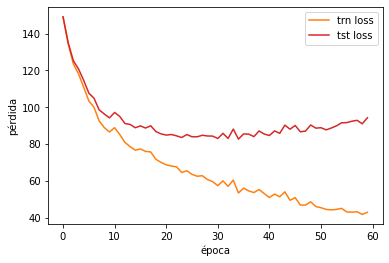

In [84]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

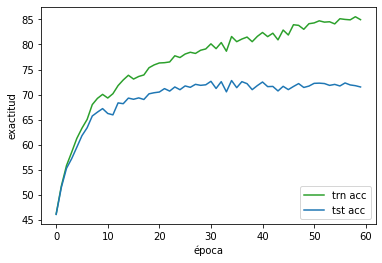

In [85]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

Esta arquitectura parece tener un buen desempeño, pero se pierde la capacidad de generalización muy rápidamente y se empieza a sobreentrenar sobre el conjunto de training.

#### Evaluación

In [86]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 42.98, 95.07] acc=[84.94,71.45]


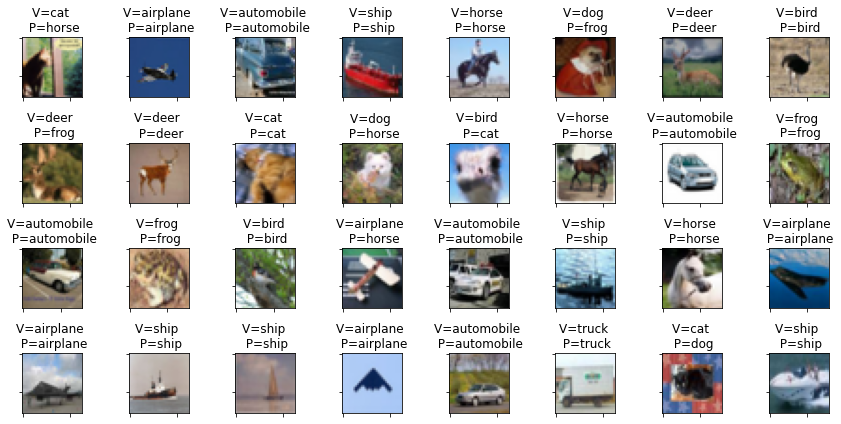

In [87]:
with torch.no_grad(): 
    x_o, y_true_o = next(iter(tst_dl))
    x = x_o.to(device)
    y_true = y_true_o.to(device)
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1).cpu()
    titles = [f'V={t} \n P={p}' for t, p in zip([classes_dataset[i] for i in y_true_o], 
                                                [classes_dataset[i] for i in y_pred])]
    display_batch(x_o, titles, ROWS, COLS)

No existieron grandes mejoras respecto al primer intento.

### Intento 4

Basado en Inception V2

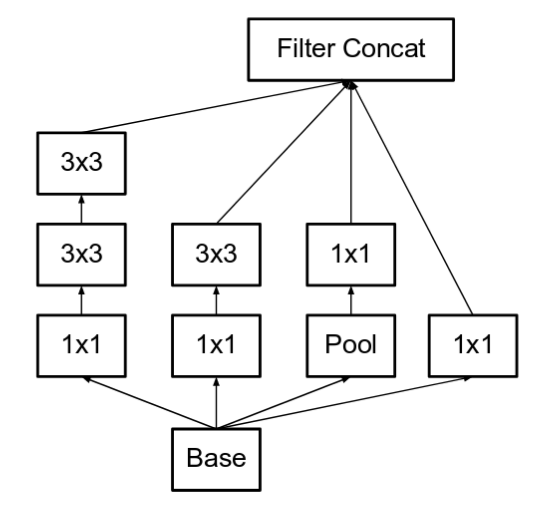

In [142]:
#Bloque de InceptionV2 + batchnorm
class InceptionBlockV2(nn.Module):

    def __init__(self, in_channels, 
                 out_channels1, out_channels3):
        super(InceptionBlockV2, self).__init__()
        self.conv1x1_1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels1, kernel_size=1)
        
        self.conv1x1_2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels1, kernel_size=1)
        
        self.conv1x1_3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels1, kernel_size=1)
        
        self.conv1x1_4 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels1, kernel_size=1)
        
        self.conv3x3_1 = nn.Conv2d(in_channels=out_channels1, out_channels=out_channels3, kernel_size=3, padding=1)
        
        self.conv3x3_2 = nn.Conv2d(in_channels=out_channels3, out_channels=out_channels3, kernel_size=3, padding=1)
        
        self.conv3x3_3 = nn.Conv2d(in_channels=out_channels1, out_channels=out_channels3, kernel_size=3, padding=1)
        
        self.maxpool_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        
        self.bn = nn.BatchNorm2d(2*out_channels1 + 2 *out_channels3)
        
    def forward(self, x):
        x1 = F.relu(self.conv1x1_1(x))
        x1 = F.relu(self.conv3x3_1(x1))
        x1 = F.relu(self.conv3x3_2(x1))
        
        x2 = F.relu(self.conv1x1_2(x))
        x2 = F.relu(self.conv3x3_3(x2))
        
        x3 = F.relu(self.maxpool_1(x))
        x3 = F.relu(self.conv1x1_3(x3))
        
        x4 = F.relu(self.conv1x1_4(x))
        
        x = torch.cat((x1, x2, x3, x4), dim=1)
        
        x = self.bn(x)
        
        return x

"""
        self.IB_A_1 = 50
        self.IB_A_3 = 35
        
        self.IB_B_1 = 60
        self.IB_B_3 = 48
        
        self.IB_C_1 = 76
        self.IB_C_3 = 60
        
        self.IB_D_1 = 32
        self.IB_D_3 = 18
        
        self.IB_E_1 = 12
        self.IB_E_3 = 12
        
        self.IB_F_1 = 4
        self.IB_F_3 = 8"""
    
class CNN(nn.Module):
    
    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()

        # definición de bloques conv
        # [M, 3, 32, 32] => [M, 24, 16, 16]
        
        #Numero de canales de salida de convoluciones 1x1 y 3x3 en cada InceptionBlock
        self.IB_A_1 = 50
        self.IB_A_3 = 35
        
        self.IB_B_1 = 60
        self.IB_B_3 = 48
        
        self.IB_C_1 = 76
        self.IB_C_3 = 60
        
        self.IB_D_1 = 32
        self.IB_D_3 = 18
        
        self.IB_E_1 = 12
        self.IB_E_3 = 12
        
        self.IB_F_1 = 4
        self.IB_F_3 = 8
        
        self.dropout_1 = nn.Dropout(p=0.05)
        self.dropout_2 = nn.Dropout(p=0.05)
        self.dropout_3 = nn.Dropout(p=0.05)
        self.dropout_4 = nn.Dropout(p=0.05)
        self.dropout_5 = nn.Dropout(p=0.05)
        
        self.cnn = nn.Sequential(

            InceptionBlockV2(3, self.IB_A_1, self.IB_A_3),
            self.dropout_1,
            InceptionBlockV2(2*self.IB_A_1 + 2*self.IB_A_3, self.IB_B_1, self.IB_B_3),
            self.dropout_2,
            InceptionBlockV2(2*self.IB_B_1 + 2*self.IB_B_3, self.IB_C_1, self.IB_C_3),
            self.dropout_3,
            InceptionBlockV2(2*self.IB_C_1 + 2*self.IB_C_3, self.IB_D_1, self.IB_D_3),
            self.dropout_4,
            InceptionBlockV2(2*self.IB_D_1 + 2*self.IB_D_3, self.IB_E_1, self.IB_E_3),
            self.dropout_5,
            InceptionBlockV2(2*self.IB_E_1 + 2*self.IB_E_3, self.IB_F_1, self.IB_F_3),
            nn.AvgPool2d(kernel_size=8)
        )
        
        self.flatten = nn.Flatten()
        
        # [M, 24 * 24 * 4] => [M, 10]
        self.cls = nn.Linear(4*4*24, 10)
        
        self.dropout_f = nn.Dropout(p=0.25)
        
    # metodo para inferencia
    def forward(self, x):
        # [M, 3, 32, 32] => [M, 24, 16, 16]
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.dropout_f(x)
        x = self.cls(x)
        return x

In [143]:
model = CNN()
print(model)

CNN(
  (dropout_1): Dropout(p=0.05, inplace=False)
  (dropout_2): Dropout(p=0.05, inplace=False)
  (dropout_3): Dropout(p=0.05, inplace=False)
  (dropout_4): Dropout(p=0.05, inplace=False)
  (dropout_5): Dropout(p=0.05, inplace=False)
  (cnn): Sequential(
    (0): InceptionBlockV2(
      (conv1x1_1): Conv2d(3, 50, kernel_size=(1, 1), stride=(1, 1))
      (conv1x1_2): Conv2d(3, 50, kernel_size=(1, 1), stride=(1, 1))
      (conv1x1_3): Conv2d(3, 50, kernel_size=(1, 1), stride=(1, 1))
      (conv1x1_4): Conv2d(3, 50, kernel_size=(1, 1), stride=(1, 1))
      (conv3x3_1): Conv2d(50, 35, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3x3_2): Conv2d(35, 35, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv3x3_3): Conv2d(50, 35, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (maxpool_1): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (bn): BatchNorm2d(170, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [144]:
# inferencia con datos sintéticos
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 32, 32]) => torch.Size([1, 10])


In [145]:
summary(model, (1, 3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 24, 4, 4]             --
|    └─InceptionBlockV2: 2-1             [1, 170, 32, 32]          --
|    |    └─Conv2d: 3-1                  [1, 50, 32, 32]           200
|    |    └─Conv2d: 3-2                  [1, 35, 32, 32]           15,785
|    |    └─Conv2d: 3-3                  [1, 35, 32, 32]           11,060
|    |    └─Conv2d: 3-4                  [1, 50, 32, 32]           200
|    |    └─Conv2d: 3-5                  [1, 35, 32, 32]           15,785
|    |    └─MaxPool2d: 3-6               [1, 3, 32, 32]            --
|    |    └─Conv2d: 3-7                  [1, 50, 32, 32]           200
|    |    └─Conv2d: 3-8                  [1, 50, 32, 32]           200
|    |    └─BatchNorm2d: 3-9             [1, 170, 32, 32]          340
├─Dropout: 1-2                           [1, 170, 32, 32]          --
├─Sequential: 1                          []                        -

In [146]:
model = CNN().to(device)
loss_hist, acc_hist, model_opt = train(model, trn_dl, tst_dl, opt = None, optimizer = optim.Adam, epochs = 20, lr = 1e-3, loss_hist = [], acc_hist = [])

  5%|▌         | 1/20 [02:41<51:14, 161.82s/it]

E00 loss=[107.32,108.63] acc=[62.01,60.87]


 10%|█         | 2/20 [05:24<48:38, 162.13s/it]

E01 loss=[ 86.21, 90.98] acc=[69.61,66.87]


 15%|█▌        | 3/20 [08:06<45:58, 162.28s/it]

E02 loss=[ 74.82, 80.53] acc=[73.74,71.71]


 20%|██        | 4/20 [10:48<43:15, 162.25s/it]

E03 loss=[ 69.99, 76.08] acc=[75.36,73.55]


 25%|██▌       | 5/20 [13:30<40:32, 162.19s/it]

E04 loss=[ 61.21, 70.18] acc=[78.49,75.20]


 30%|███       | 6/20 [16:12<37:50, 162.15s/it]

E05 loss=[ 56.79, 66.99] acc=[80.03,76.63]


 35%|███▌      | 7/20 [18:55<35:07, 162.11s/it]

E06 loss=[ 53.14, 64.94] acc=[81.50,77.23]


 40%|████      | 8/20 [21:37<32:25, 162.09s/it]

E07 loss=[ 50.49, 63.71] acc=[82.19,77.93]


 45%|████▌     | 9/20 [24:18<29:42, 162.04s/it]

E08 loss=[ 48.64, 64.07] acc=[82.83,77.86]


 50%|█████     | 10/20 [27:00<26:59, 161.91s/it]

E09 loss=[ 44.86, 60.87] acc=[84.07,79.12]


 55%|█████▌    | 11/20 [29:43<24:20, 162.22s/it]

E10 loss=[ 41.83, 60.60] acc=[85.33,79.57]


 60%|██████    | 12/20 [32:26<21:39, 162.43s/it]

E11 loss=[ 38.06, 60.65] acc=[86.85,79.56]


 65%|██████▌   | 13/20 [35:09<18:58, 162.62s/it]

E12 loss=[ 36.68, 59.87] acc=[87.10,80.09]


 70%|███████   | 14/20 [37:52<16:16, 162.79s/it]

E13 loss=[ 34.58, 58.15] acc=[88.02,80.36]


 75%|███████▌  | 15/20 [40:35<13:34, 162.91s/it]

E14 loss=[ 33.08, 61.42] acc=[88.43,80.04]


 80%|████████  | 16/20 [43:19<10:51, 162.98s/it]

E15 loss=[ 31.84, 61.07] acc=[88.81,80.00]


 85%|████████▌ | 17/20 [46:02<08:09, 163.03s/it]

E16 loss=[ 30.58, 59.31] acc=[89.09,80.87]


 90%|█████████ | 18/20 [48:45<05:26, 163.21s/it]

E17 loss=[ 26.57, 58.88] acc=[90.65,80.80]


 95%|█████████▌| 19/20 [51:28<02:43, 163.14s/it]

E18 loss=[ 27.24, 61.59] acc=[90.32,80.34]


100%|██████████| 20/20 [54:12<00:00, 162.60s/it]

E19 loss=[ 25.02, 60.53] acc=[91.30,80.79]


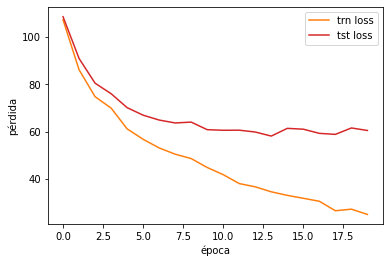

In [147]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

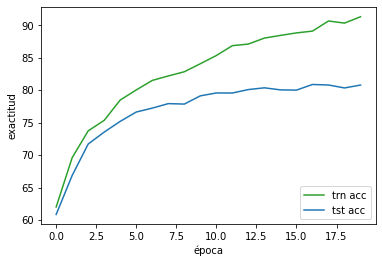

In [148]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

### Evaluación

In [149]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 25.24, 62.54] acc=[91.05,80.60]


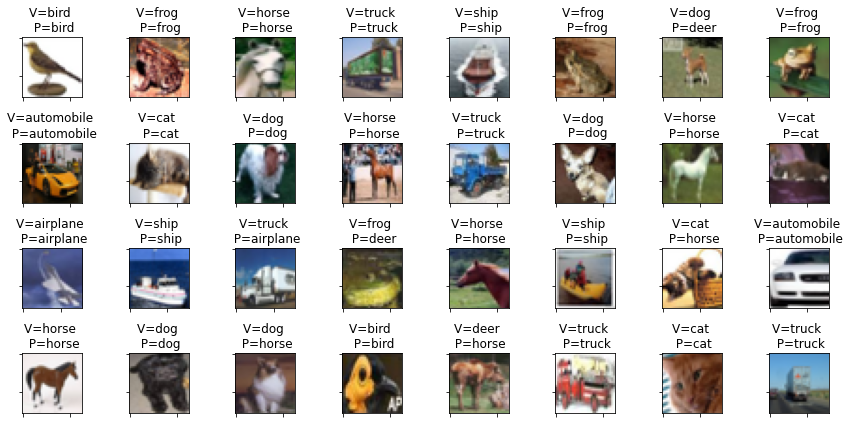

In [150]:
with torch.no_grad(): 
    x_o, y_true_o = next(iter(tst_dl))
    x = x_o.to(device)
    y_true = y_true_o.to(device)
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1).cpu()
    titles = [f'V={t} \n P={p}' for t, p in zip([classes_dataset[i] for i in y_true_o], 
                                                [classes_dataset[i] for i in y_pred])]
    display_batch(x_o, titles, ROWS, COLS)

Aunque claramente da mejores resultados que la fully-connected, parece que todavía existe el problema del sobreentrenamiento. Aunque parece que la red tiene la suficiente complejidad para tener una accuracy muy alta en el conjunto de entrenamiento, se estanca muy rapido el desempeño en el conjunto de prueba.

Podría ser buena idea recolectar más datos o introducir otras medidas de regularización como L1/L2. De igual manera un cambio a otra arquitectura podría dar mejores resultados, ya que para este conjunto de datos los mejores resultados que he encontrado son de un $95\%$ en el conjunto de prueba.